In [8]:
import keras
keras.__version__

'2.2.4'

## Almost state-of-the-art computer vision

Keras comes prepackaged with some of the state-of-the-art machine vision models that have been previously pretrained on large clusters of GPUs using millions of images as training data. 

Using this pre-train models, you have programmatic access to state-of-the-art machine vision that you can incorporate into your software projects. Here is the list of image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate ResNet50 and check out its performance on the following images

<img src="./images/car.jpg" alt="Drawing" style="height: 200px; float: left;"/>
<img src="./images/elephant.jpg" alt="Drawing" float="left" style="height: 200px;  float: left;"/>
<img src="./images/chair.jpg" alt="Drawing" style="height: 200px; float: left;"/>


In [9]:
import numpy as np
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet')

img_path = './images/car.jpg'
# img_path = './images/elephant.jpg'
# img_path = './images/chair.jpg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted:', decode_predictions(preds))

Predicted: [[('n04285008', 'sports_car', 0.37167186), ('n02930766', 'cab', 0.14883095), ('n02814533', 'beach_wagon', 0.09638426), ('n03930630', 'pickup', 0.06842637), ('n04037443', 'racer', 0.055562854)]]


Change the name of the input file and check the performance of the ResNet50 model on the other images, or some images of your choice.

# Transfer learning - Using a pre-trained convnet

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems might involve completely different classes from those of the original task. For instance, one might train a network on ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). 




## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

![swapping FC classifiers](./images/swapping_fc_classifier.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of  classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

Let's put this in practice by using the convolutional base of the InceptionV3 network, trained on ImageNet, to extract interesting features from the data set of cats and dog images we used in the previous practical, and then training a cat vs. dog classifier on top of these features.

Let's instantiate the InceptionV3 model:

In [34]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the InceptionV3 convolutional base: it's very similar to the simple convnets that you are already familiar with.

In [35]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 74, 74, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 74, 74, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_340 (Activation)     (None, 74, 74, 32)   0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

Notice, how this is a very sophisticated model with more than 21 million parameters (weights) that have been pre-tuned by training the model on millions of images on clusters of thousands of GPUs.

The final feature map has shape `(3, 3, 2048)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, we will run the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier. 

Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our  data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

Before you run the following code snippet, make sure you download the data set `cats_and_dogs_small.rar` from:

`I:\COURSES\ITP\BITY3\IN726-dsmi-data`

containing a bunch of images of cats and dogs and point the `base_dir` variable below to the folder where you uncompressed the images.

The following code snippet extracts the last output feature map from the InceptionV3 model when we feed it our data of cats and dogs:

In [38]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = r".\cats_and_dogs_small"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    #Notice that the dimensions of the features variable coincide with the output of the pretrained convnet!!!!!!!
    features = np.zeros(shape=(sample_count, 3, 3, 2048)) 
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 100)
validation_features, validation_labels = extract_features(validation_dir, 100)
test_features, test_labels = extract_features(test_dir, 100)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must flatten them to `(samples, 8192)`:

In [39]:
train_features = np.reshape(train_features, (100, 3 * 3 * 2048))
validation_features = np.reshape(validation_features, (100, 3 * 3 * 2048))
test_features = np.reshape(test_features, (100, 3 * 3 * 2048))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization).

In [52]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=3 * 3 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

Finally, let's train the new model on the data features extracted using the pre-trained convnet:

In [53]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 100 samples, validate on 100 samples
Epoch 1/30
100/100 [==============================] - 6s 64ms/step - loss: 1.2964 - acc: 0.6300 - val_loss: 0.2282 - val_acc: 0.9000
Epoch 2/30
100/100 [==============================] - 0s 682us/step - loss: 0.4412 - acc: 0.8500 - val_loss: 0.1658 - val_acc: 0.9500
Epoch 3/30
100/100 [==============================] - 0s 683us/step - loss: 0.1404 - acc: 0.9300 - val_loss: 0.1503 - val_acc: 0.9400
Epoch 4/30
100/100 [==============================] - 0s 663us/step - loss: 0.1224 - acc: 0.9500 - val_loss: 0.1606 - val_acc: 0.9400
Epoch 5/30
100/100 [==============================] - 0s 836us/step - loss: 0.0622 - acc: 0.9900 - val_loss: 0.1293 - val_acc: 0.9400
Epoch 6/30
100/100 [==============================] - 0s 832us/step - loss: 0.1401 - acc: 0.9600 - val_loss: 0.1216 - val_acc: 0.9300
Epoch 7/30
100/100 [==============================] - 0s 663us/step - loss: 0.0749 - acc: 0.9600 - val_loss: 0.1299 - val_acc: 0.9400
Epoch 8/30
100/10

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

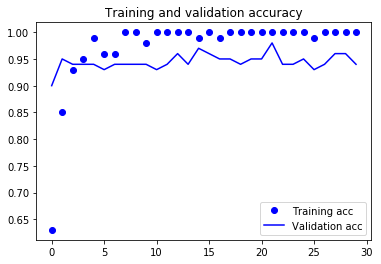

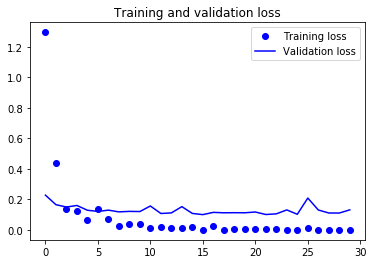

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We reach a validation accuracy of around 94%, much better than what we could achieve training from scratch with so little data (as we did in the previous practical were accuracy without data augmentation was on the low 70s). 
Finally, let's print the accuracy of our model on the test set.

In [57]:
[loss, accuracy] = model.evaluate(test_features, test_labels)

100/100 [==============================] - 0s 748us/step


In [58]:
print(accuracy)

0.92


How about that? you just created a machine vision system able to discriminate cats from dogs in digital images with almost perfect accuracy!

----------